In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd

plt.style.use('ggplot')
pd.set_option('display.max_columns', 30)

In [2]:
df = pd.read_csv('data/citibike_ZIP.csv')
df.head()

,tripduration,starttime,stoptime,start_id,start_name,start_lat,start_lon,end_id,end_name,end_lat,end_lon,bikeid,usertype,birth_year,gender,weekday,hour,geometry,zip_start,zip_end
0,17.700000,2020-06-01 00:00:03.372,2020-06-01 00:17:46.208,3419,Douglass St & 4 Ave,40.679279,-73.981540,3419,Douglass St & 4 Ave,40.679279,-73.981540,39852,Customer,1997,2,0,0,POINT (989370.1838770027 186756.53892500512),11217,11217.0
1,63.500000,2020-06-01 00:00:03.553,2020-06-01 01:03:33.936,366,Clinton Ave & Myrtle Ave,40.693261,-73.968896,336,Sullivan St & Washington Sq,40.730477,-73.999061,37558,Subscriber,1969,0,0,0,POINT (992875.4144866021 191851.65323921342),11205,10012.0
2,16.950000,2020-06-01 00:00:09.614,2020-06-01 00:17:06.833,389,Broadway & Berry St,40.710446,-73.965251,3562,Classon Ave & St Marks Ave,40.676520,-73.959608,37512,Customer,1988,2,0,0,POINT (993883.8241576733 198112.87322040228),11249,11238.0
3,3.766667,2020-06-01 00:00:12.178,2020-06-01 00:03:58.864,3255,8 Ave & W 31 St,40.750585,-73.994685,505,6 Ave & W 33 St,40.749013,-73.988484,39674,Customer,1969,0,0,0,POINT (985722.6805079061 212735.19209770544),10001,10001.0
4,23.950000,2020-06-01 00:00:21.255,2020-06-01 00:24:18.965,367,E 53 St & Lexington Ave,40.758281,-73.970694,497,E 17 St & Broadway,40.737050,-73.990093,21093,Customer,1997,2,0,0,POINT (992368.8021711168 215540.1540624901),10022,10003.0


In [3]:
# supply and demand

starts_hrly = df.groupby(['hour','zip_start'], as_index = False)[['bikeid']].count()
starts_hrly.columns = ['hour','zip_start','start_count']
starts_hrly

,hour,zip_start,start_count
0,0,83,274
1,0,10001,554
2,0,10002,705
3,0,10003,811
4,0,10004,68
...,...,...,...
1717,23,11237,289
1718,23,11238,525
1719,23,11249,800
1720,23,11251,29


In [4]:
ends_hrly = df.groupby(['hour','zip_end'], as_index = False)[['bikeid']].count()
ends_hrly.columns = ['hour','zip_end','end_count']
ends_hrly

,hour,zip_end,end_count
0,0,83.0,213
1,0,10001.0,562
2,0,10002.0,762
3,0,10003.0,785
4,0,10004.0,82
...,...,...,...
1717,23,11237.0,321
1718,23,11238.0,531
1719,23,11249.0,482
1720,23,11251.0,37


In [5]:
supply_hrly = starts_hrly.merge(ends_hrly,
                               left_on = ['hour','zip_start'],
                               right_on = ['hour','zip_end'],
                               how = 'outer')
supply_hrly.head(10)

,hour,zip_start,start_count,zip_end,end_count
0,0,83.0,274.0,83.0,213.0
1,0,10001.0,554.0,10001.0,562.0
2,0,10002.0,705.0,10002.0,762.0
3,0,10003.0,811.0,10003.0,785.0
4,0,10004.0,68.0,10004.0,82.0
5,0,10005.0,118.0,10005.0,124.0
6,0,10007.0,201.0,10007.0,175.0
7,0,10009.0,623.0,10009.0,675.0
8,0,10010.0,156.0,10010.0,191.0
9,0,10011.0,626.0,10011.0,549.0


In [6]:
supply_hrly['end_count'].fillna(0, inplace=True)
supply_hrly['start_count'].fillna(0, inplace=True)

In [7]:
# define hourly surplus as the difference between hourly end count and start count at a station
# find daily average by dividing by 28

supply_hrly['hrly_surplus'] = (supply_hrly['end_count'] - supply_hrly['start_count'])/30
supply_hrly.head()

,hour,zip_start,start_count,zip_end,end_count,hrly_surplus
0,0,83.0,274.0,83.0,213.0,-2.033333
1,0,10001.0,554.0,10001.0,562.0,0.266667
2,0,10002.0,705.0,10002.0,762.0,1.900000
3,0,10003.0,811.0,10003.0,785.0,-0.866667
4,0,10004.0,68.0,10004.0,82.0,0.466667


In [8]:
supply_hrly.sort_values(by = ['hrly_surplus']).head(3)
# top 3 deficit are Central Park at 7-8pm, Murray Hill at 4pm

,hour,zip_start,start_count,zip_end,end_count,hrly_surplus
1434,20,83.0,4014.0,83.0,2629.0,-46.166667
1362,19,83.0,6098.0,83.0,4738.0,-45.333333
1159,16,10016.0,6208.0,10016.0,4908.0,-43.333333


In [9]:
supply_hrly.sort_values(by = ['hrly_surplus'], ascending = False).head(3)
# top 3 surplus are Murray Hill at 7am and East Village at 5-6pm

,hour,zip_start,start_count,zip_end,end_count,hrly_surplus
439,6,10016.0,1618.0,10016.0,3045.0,47.566667
1225,17,10009.0,5918.0,10009.0,7192.0,42.466667
462,6,10065.0,599.0,10065.0,1825.0,40.866667


In [11]:
rides_AM = supply_hrly[(supply_hrly['hour'] > 4) & (supply_hrly['hour'] < 11)] # 5-10 am
rides_PM = supply_hrly[(supply_hrly['hour'] > 15) & (supply_hrly['hour'] < 22)] # 4-9 pm

In [12]:
count_AM = rides_AM.groupby('zip_start', as_index = False)['start_count','end_count'].sum()
count_AM.columns = ['zip','start_AM','end_AM']
count_PM = rides_PM.groupby('zip_start', as_index = False)['start_count','end_count'].sum()
count_PM.columns = ['zip','start_PM','end_PM']
count_PM.head()

/var/folders/br/94g31g292jj5vykvq71cy53m0000gn/T/ipykernel_72317/2679753019.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  count_AM = rides_AM.groupby('zip_start', as_index = False)['start_count','end_count'].sum()
/var/folders/br/94g31g292jj5vykvq71cy53m0000gn/T/ipykernel_72317/2679753019.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  count_PM = rides_PM.groupby('zip_start', as_index = False)['start_count','end_count'].sum()


,zip,start_PM,end_PM
0,83.0,35312.0,30912.0
1,10001.0,27326.0,25029.0
2,10002.0,32600.0,35506.0
3,10003.0,40910.0,40819.0
4,10004.0,5346.0,4749.0


In [13]:
commute_count = count_AM.merge(count_PM,
                       on = 'zip')
commute_count['surplus_AM'] = commute_count['end_AM'] - commute_count['start_AM']
commute_count['surplus_PM'] = commute_count['end_PM'] - commute_count['start_PM']
commute_count['surplus_AM_daily'] = commute_count['surplus_AM']/28
commute_count['surplus_PM_daily'] = commute_count['surplus_PM']/28
commute_count.head()

,zip,start_AM,end_AM,start_PM,end_PM,surplus_AM,surplus_PM,surplus_AM_daily,surplus_PM_daily
0,83.0,9726.0,10629.0,35312.0,30912.0,903.0,-4400.0,32.250000,-157.142857
1,10001.0,12382.0,13286.0,27326.0,25029.0,904.0,-2297.0,32.285714,-82.035714
2,10002.0,13568.0,11054.0,32600.0,35506.0,-2514.0,2906.0,-89.785714,103.785714
3,10003.0,15458.0,16197.0,40910.0,40819.0,739.0,-91.0,26.392857,-3.250000
4,10004.0,1667.0,2316.0,5346.0,4749.0,649.0,-597.0,23.178571,-21.321429


In [14]:
# aggregated for PM hours:
# top 1 deficit is Central Park (83)
# top 3 deficits are Central Park, Lenox Hill, Murray Hill
commute_count.sort_values(by = ['surplus_PM_daily']).head(3)

,zip,start_AM,end_AM,start_PM,end_PM,surplus_AM,surplus_PM,surplus_AM_daily,surplus_PM_daily
0,83.0,9726.0,10629.0,35312.0,30912.0,903.0,-4400.0,32.250000,-157.142857
36,10065.0,6418.0,9798.0,12683.0,9203.0,3380.0,-3480.0,120.714286,-124.285714
13,10016.0,13918.0,17993.0,28287.0,25424.0,4075.0,-2863.0,145.535714,-102.250000


In [15]:
# aggregated for PM hours:
# top 1 surplus is East village (10009)
# top 3 surplus are East Village, LES, Bushwick/BedStuy
commute_count.sort_values(by = ['surplus_PM_daily'], ascending = False).head(3)

,zip,start_AM,end_AM,start_PM,end_PM,surplus_AM,surplus_PM,surplus_AM_daily,surplus_PM_daily
7,10009.0,12833.0,8370.0,26545.0,32376.0,-4463.0,5831.0,-159.392857,208.250000
2,10002.0,13568.0,11054.0,32600.0,35506.0,-2514.0,2906.0,-89.785714,103.785714
57,11211.0,6832.0,5986.0,21017.0,22820.0,-846.0,1803.0,-30.214286,64.392857


In [16]:
# aggregated for AM hours:
# top 1 deficit is East Village (10009)
# top 3 deficits are East Village, LES, UWS
commute_count.sort_values(by = ['surplus_AM_daily']).head(3)

,zip,start_AM,end_AM,start_PM,end_PM,surplus_AM,surplus_PM,surplus_AM_daily,surplus_PM_daily
7,10009.0,12833.0,8370.0,26545.0,32376.0,-4463.0,5831.0,-159.392857,208.250000
2,10002.0,13568.0,11054.0,32600.0,35506.0,-2514.0,2906.0,-89.785714,103.785714
20,10024.0,7309.0,5096.0,15462.0,15913.0,-2213.0,451.0,-79.035714,16.107143


In [17]:
# aggregated for AM hours:
# top 1 surplus is Murray Hill (10016)
# top 3 surplus are Murray Hill, Midtown East, Lenox Hill
commute_count.sort_values(by = ['surplus_AM_daily'], ascending = False).head(3)

,zip,start_AM,end_AM,start_PM,end_PM,surplus_AM,surplus_PM,surplus_AM_daily,surplus_PM_daily
13,10016.0,13918.0,17993.0,28287.0,25424.0,4075.0,-2863.0,145.535714,-102.250000
14,10017.0,5280.0,8791.0,10791.0,8545.0,3511.0,-2246.0,125.392857,-80.214286
36,10065.0,6418.0,9798.0,12683.0,9203.0,3380.0,-3480.0,120.714286,-124.285714


In [18]:
zip_shp = gpd.read_file('nyc_zip/ZIP_CODE_040114.shp')
zip_shp['ZIPCODE'] = zip_shp['ZIPCODE'].astype(int)

In [19]:
zip_shp = zip_shp.merge(
    commute_count, 
    left_on='ZIPCODE',
    right_on='zip',
    how='left')
zip_shp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,zip,start_AM,end_AM,start_PM,end_PM,surplus_AM,surplus_PM,surplus_AM_daily,surplus_PM_daily
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18...",11225.0,1452.0,1101.0,4403.0,4586.0,-351.0,183.0,-12.535714,6.535714
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
zip_shp['surplus_AM'].fillna(0, inplace=True)
zip_shp['surplus_PM'].fillna(0, inplace=True)
zip_shp['surplus_AM_daily'].fillna(0, inplace=True)
zip_shp['surplus_PM_daily'].fillna(0, inplace=True)

In [21]:
start_PM = df.groupby(['zip_start','zip_end'], as_index = False)[['bikeid']].count().\
    rename(columns = {'bikeid': 'count'})
start_PM['daily_avg'] = start_PM['count']/28
start_PM.sort_values(by = 'daily_avg', ascending = False).head(10)

,zip_start,zip_end,count,daily_avg
3341,11201,11201.0,24827,886.678571
144,10002,10002.0,23012,821.857143
0,83,83.0,19924,711.571429
623,10011,10011.0,16892,603.285714
215,10003,10003.0,16352,584.000000
480,10009,10009.0,15965,570.178571
2972,11101,11101.0,15586,556.642857
1742,10029,10029.0,12608,450.285714
3640,11215,11215.0,11757,419.892857
3579,11211,11211.0,11344,405.142857


In [22]:
end_PM = df.groupby(['zip_end','zip_start'], as_index = False)[['bikeid']].count().\
    rename(columns = {'bikeid': 'count'})
end_PM['daily_avg'] = end_PM['count']/28
end_PM.sort_values(by = 'daily_avg', ascending = False).head(10)

,zip_end,zip_start,count,daily_avg
3337,11201.0,11201,24827,886.678571
142,10002.0,10002,23012,821.857143
0,83.0,83,19924,711.571429
631,10011.0,10011,16892,603.285714
212,10003.0,10003,16352,584.000000
489,10009.0,10009,15965,570.178571
2966,11101.0,11101,15586,556.642857
1735,10029.0,10029,12608,450.285714
3641,11215.0,11215,11757,419.892857
3575,11211.0,11211,11344,405.142857


In [23]:
PM_centpark = start_PM[start_PM['zip_start'] == 83]
PM_centpark.sort_values(by = 'count', ascending = False).head(10)

,zip_start,zip_end,count,daily_avg
0,83,83.0,19924,711.571429
16,83,10019.0,5446,194.500000
19,83,10023.0,4259,152.107143
20,83,10024.0,3395,121.250000
21,83,10025.0,3275,116.964286
22,83,10026.0,2820,100.714286
25,83,10029.0,2808,100.285714
17,83,10021.0,2304,82.285714
23,83,10027.0,2045,73.035714
24,83,10028.0,1996,71.285714


In [24]:
PM_eastvil = end_PM[end_PM['zip_end'] == 10009]
PM_eastvil.sort_values(by = 'count', ascending = False).head(10)

,zip_end,zip_start,count,daily_avg
489,10009.0,10009,15965,570.178571
485,10009.0,10003,9328,333.142857
484,10009.0,10002,7623,272.250000
495,10009.0,10016,4118,147.071429
491,10009.0,10011,3124,111.571429
494,10009.0,10014,2782,99.357143
492,10009.0,10012,2323,82.964286
490,10009.0,10010,2021,72.178571
493,10009.0,10013,1849,66.035714
483,10009.0,10001,1517,54.178571


In [25]:
zip_fromcentpark = zip_shp.merge(
    PM_centpark, 
    left_on='ZIPCODE',
    right_on='zip_end',
    how='left')
zip_fromcentpark.sort_values(by = 'count', ascending = False).head(6)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,zip,start_AM,end_AM,start_PM,end_PM,surplus_AM,surplus_PM,surplus_AM_daily,surplus_PM_daily,zip_start,zip_end,count,daily_avg
54,83,0,Central Park,25.0,3.830099e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((998309.725 229616.681, 998282.853 22...",83.0,9726.0,10629.0,35312.0,30912.0,903.0,-4400.0,32.250000,-157.142857,83.0,83.0,19924.0,711.571429
187,10019,0,New York,41966.0,1.882838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((986161.713 220802.608, 986480.821 22...",10019.0,12370.0,14323.0,28382.0,27430.0,1953.0,-952.0,69.750000,-34.000000,83.0,10019.0,5446.0,194.500000
60,10023,0,New York,62800.0,1.521271e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((986170.321 221389.159, 986464.435 22...",10023.0,7749.0,6862.0,20290.0,19746.0,-887.0,-544.0,-31.678571,-19.428571,83.0,10023.0,4259.0,152.107143
46,10024,0,New York,58521.0,2.287734e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((994210.038 234868.661, 994182.279 23...",10024.0,7309.0,5096.0,15462.0,15913.0,-2213.0,451.0,-79.035714,16.107143,83.0,10024.0,3395.0,121.250000
51,10025,0,New York,96054.0,1.963104e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((995501.655 232971.115, 995396.152 23...",10025.0,6097.0,4375.0,12627.0,13705.0,-1722.0,1078.0,-61.500000,38.500000,83.0,10025.0,3275.0,116.964286
48,10026,0,New York,34313.0,1.109268e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((999588.262 231919.431, 999462.779 23...",10026.0,3515.0,2635.0,8869.0,9970.0,-880.0,1101.0,-31.428571,39.321429,83.0,10026.0,2820.0,100.714286


In [26]:
zip_fromcentpark['daily_avg'].fillna(0, inplace = True)

In [27]:
zip_toeastvil = zip_shp.merge(
    PM_eastvil, 
    left_on='ZIPCODE',
    right_on='zip_start',
    how='left')
zip_toeastvil.sort_values(by = 'count', ascending = False).head(6)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,zip,start_AM,end_AM,start_PM,end_PM,surplus_AM,surplus_PM,surplus_AM_daily,surplus_PM_daily,zip_end,zip_start,count,daily_avg
94,10009,0,New York,61455.0,1.590352e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991606.403 205494.146, 991619.927 20...",10009.0,12833.0,8370.0,26545.0,32376.0,-4463.0,5831.0,-159.392857,208.250000,10009.0,10009.0,15965.0,570.178571
90,10003,0,New York,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",10003.0,15458.0,16197.0,40910.0,40819.0,739.0,-91.0,26.392857,-3.250000,10009.0,10003.0,9328.0,333.142857
92,10002,0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",10002.0,13568.0,11054.0,32600.0,35506.0,-2514.0,2906.0,-89.785714,103.785714,10009.0,10002.0,7623.0,272.250000
84,10016,0,New York,54606.0,1.504240e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989286.343 213322.780, 989730.129 21...",10016.0,13918.0,17993.0,28287.0,25424.0,4075.0,-2863.0,145.535714,-102.250000,10009.0,10016.0,4118.0,147.071429
83,10011,0,New York,50594.0,1.811842e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((986378.434 210178.599, 986279.129 20...",10011.0,13288.0,12358.0,35582.0,36805.0,-930.0,1223.0,-33.214286,43.678571,10009.0,10011.0,3124.0,111.571429
89,10014,0,New York,31328.0,1.415105e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((983985.485 205856.726, 983867.870 20...",10014.0,10899.0,11001.0,32885.0,33350.0,102.0,465.0,3.642857,16.607143,10009.0,10014.0,2782.0,99.357143


In [28]:
zip_toeastvil['daily_avg'].fillna(0, inplace = True)

[]

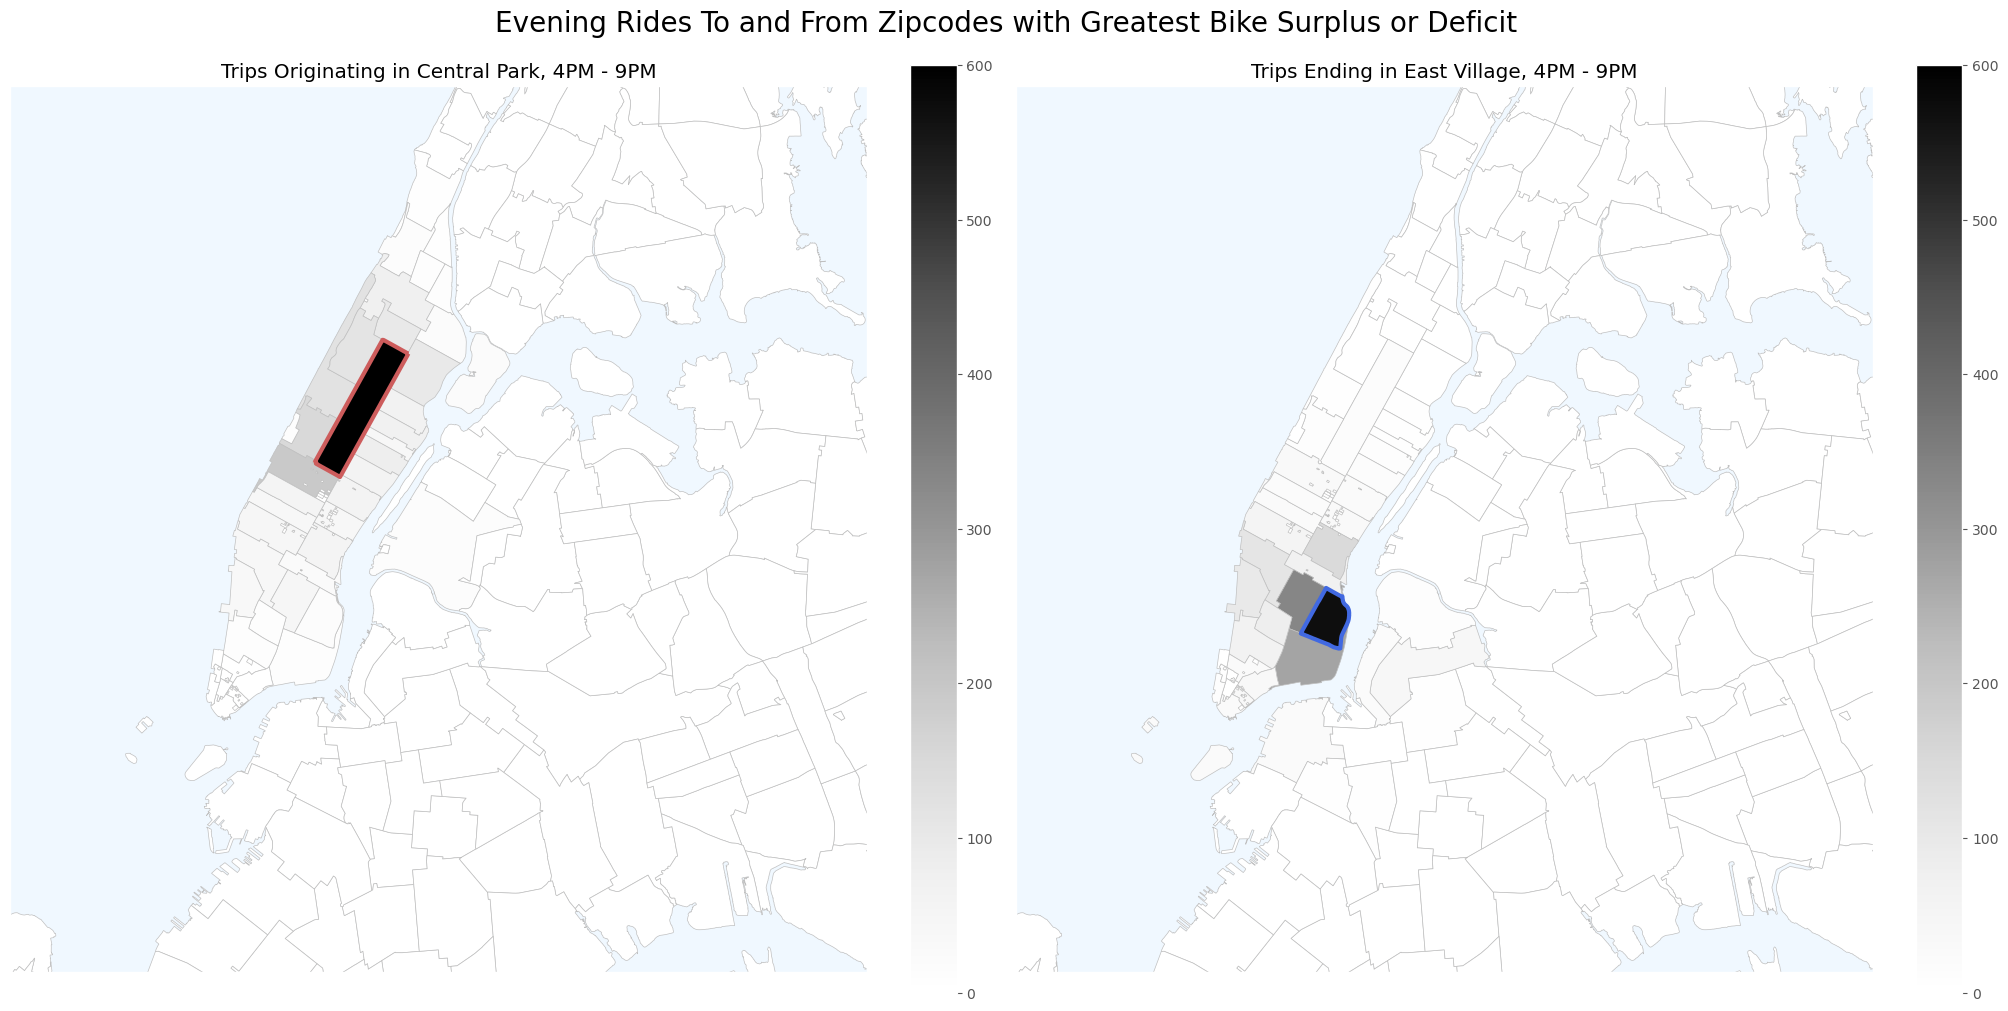

In [31]:
from matplotlib.colors import Normalize
norm = Normalize(vmin=0, vmax=600)

fig, (ax1, ax2) = plt.subplots(1,2, 
                        figsize=(20, 10),
                        sharex=False,
                        sharey=False,
                        constrained_layout=True)
fig.suptitle('Evening Rides To and From Zipcodes with Greatest Bike Surplus or Deficit', fontsize=20)

zip_fromcentpark.plot(ax=ax1, column= 'daily_avg', norm=norm, cmap='Greys', edgecolor = 'silver', legend=True)
zip_fromcentpark.loc[zip_shp['ZIPCODE'] == 83].plot(
    ax=ax1, column= 'daily_avg', norm=norm, cmap='Greys', edgecolor='indianred', linewidth = 3)

ax1.title.set_text('Trips Originating in Central Park, 4PM - 9PM')
ax1.set_xlim(960000, 1042546)
ax1.set_ylim(170056, 255352)
ax1.set_facecolor("aliceblue")
ax1.grid(False)
ax1.set_xticks([])
ax1.set_yticks([])

zip_toeastvil.plot(ax=ax2, column='daily_avg', norm=norm, cmap='Greys', edgecolor = 'silver', legend=True)
zip_toeastvil.loc[zip_shp['ZIPCODE'] == 10009].plot(
    ax=ax2, column= 'daily_avg', norm=norm, cmap='Greys', edgecolor='royalblue', linewidth = 3)

ax2.title.set_text('Trips Ending in East Village, 4PM - 9PM')
ax2.set_xlim(960000, 1042546)
ax2.set_ylim(170056, 255352)
ax2.set_facecolor("aliceblue")
ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])